# Определение перспективного тарифа для федерального оператора сотовой связи

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

## Изучение данных 

### Датасет users

In [2]:
users = pd.read_csv('/datasets/users.csv')
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [5]:
#посмотрим на пропуски
users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

>1. Датасет содержит 500 строк c id пользователей. Исходя из условия, у нас в распоряжении как раз должно быть 500 клиентов. Но стоит все равно проверить данные на дубликаты    
>2. Пропуски содержит только признак churn_date. Но по условию здесь у нас указана дата прекращения пользования тарифом, соответственно пропуски - это нормально и тариф действовал на момент выгрузки. С этим признаком ничего не делаем.  
>3. Типы данных. Стоило бы привести признаки churn_date и reg_date к временному типу данных, но они не влияют на решение задачи, поэтому для экономии времени опустим этот момент
>4. Названия признаков корректные и понятные  
>5. Ошибок и других странностей нет  
>6. С этим датасетом в предобработке ничего не нужно делать

In [6]:
print('Количество дубликатов id пользователей равно', users['user_id'].duplicated().sum())

Количество дубликатов id пользователей равно 0


### Датасет calls

In [7]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head(10)


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [10]:
calls.isnull().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

> 1. В датасете calls количество строк значительно превышает количество уникальных пользователей из предыдущего датасета и сразу видны дубликаты в user_id. Это логично, большинство пользователей за период выполняют больше, чем 1 звонок.  
>2.  Call_date  - нужно привести к временному типу данных, т.к. необходимо выделить расход каждого пользователя по месяцам  
>3. Duration - округлим до большего целого числа, т.к. в условии указано, что оператор округляет продолжительность звонка в большую сторону, поменяем тип данных на int  
>4. В условии задачи было указано, что нули в duration не являются ошибкой  
>5. Пропусков нет.  

### Датасет internet

In [11]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head(10)


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [13]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [14]:
internet.isnull().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

>1. В internet аналогичная ситуация с user_id (как и в calls), что тоже логично, т.к. пользователь часто выполняет больше одной сессии за период
>2. Mb_used - по условию интернет-трафик тоже округляется в большую сторону до Гб, однако уже после завершения периода действия тарифа. Соответственно, округлим уже при подсчете трафика по месяцам. Тип данных пока соответствует действительности. После округления логично привести к типу int
>3. Session_date - аналогичная ситуация, как и с call_date - приведем данные к временному типу
>4. Пропущенные значения отсутствуют  
>5. Здесь еще смущает название признака id. Предполагается, что это id - уникальный номер сессии. Однако название признака полностью совпадает с названием уникального номера звонка в датасете calls. Для решения задачи нам эти признаки не нужны, поэтому позволим себе не переименовывать их. Если бы ситуация была противоположной, нужно было бы дать более корректные названия.

### Датасет messages

In [15]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head(10)


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [17]:
messages.isnull().sum()

id              0
message_date    0
user_id         0
dtype: int64

>1. В messages аналогичная ситуация с users_id (как и в calls, internet). Логикак такая же, так что в этом нет ничего страшного 
>2. Message_date - привeдем к временному типу
>3. Пропущенные значения отсутствуют  
>4. Смущает также название признака id. Переименовывать не будем, как и в варианте с internet

### Датасет tariffs

In [18]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [19]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


>1. Удобная таблица с информацией по всем тарифам.  
>2. При присоединении таблицы скорее всего потребуется перименовать столбец tariff_name  
>3. Стоит перевести mb_per_month_included в гб.  
>4. Дубликаты и пропуски отсутствуют (это видно и визуально)

## Подготовка данных

### Количество звонков и израсходованных минут

In [20]:
#округляем duration
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

# приводим call_date к нужному типу данных
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
#calls.head()
#calls.info()

In [21]:
#добавляем столбец с месяцем
calls['month'] = calls['call_date'].dt.month
#calls.head()

Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам

In [22]:
calls_grouped = calls.groupby(['user_id', 'month']).agg({'duration': ['count', 'sum']}).reset_index()
#calls_grouped.head()

In [23]:
#переименовываем столбцы
calls_grouped.columns = ['user_id', 'month', 'calls_number', 'calls_duration']
#calls_grouped.info()
#calls_grouped.head()

### Объем израсходованного интернет-трафика по месяцам

In [24]:
#привели данные в session_date к временному типу
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
#internet.info()

In [25]:
#добавим столбец с месяцем
internet['month'] = internet['session_date'].dt.month
#internet.head(10)

In [26]:
# считаем для каждого пользователя объем израсходованного трафика по месяцам
internet_grouped = internet.groupby(['user_id','month']).agg({'mb_used': 'sum'}).reset_index()

# переводим в Гб и переименовываем колонку
internet_grouped['mb_used'] = internet_grouped['mb_used'] / 1024 
internet_grouped = internet_grouped.rename(columns={'mb_used': 'gb_used'})

# округляем до целых в большую сторону
internet_grouped['gb_used'] = internet_grouped['gb_used'].apply(np.ceil).astype(int)

#internet_grouped.head()
#internet_grouped.info()


### Количество отправленных сообщений по месяцам

In [27]:
#Приводим нужный столбец к временному типу данных
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%dT%H:%M:%S')
#messages.info()

In [28]:
#добавим месяц
messages['month'] = messages['message_date'].dt.month
#messages.head()

In [29]:
#считаем для каждого пользователя количество отправленных сообщений по месяцам
messages_grouped = messages.groupby(['user_id','month']).agg({'id': 'count'}).reset_index()

#переименуем столбцы
messages_grouped = messages_grouped.rename(columns={'id': 'messages'})

#messages_grouped.head()

### Датасет с тарифами

In [30]:
#Переименуем столбец tariff_name в tariff, чтобы потом склеить
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

#Переведем mb_per_month_included в gb и переименуем столбец

tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs = tariffs.rename(columns={'mb_per_month_included': 'gb_per_month_included'})
tariffs['gb_per_month_included'] = tariffs['gb_per_month_included'].astype(int)
#display(tariffs)

### Помесячная выручка с каждого пользователя

Объединим все наши таблицы в одну, чтобы рассчитать помесячную выручку с каждого пользователя

In [31]:
users_1 = calls_grouped.merge(internet_grouped, on = ['user_id', 'month'], how = 'outer').merge(messages_grouped, on = ['user_id', 'month'], how = 'outer').fillna(0)
#display(users_1)
#users_1.info()
users_2 = users_1.merge(users, on = 'user_id', how = 'left')
#display(users_2)
users_final = users_2.merge(tariffs, on = 'tariff', how = 'left')
#users_final.head()
#users_final.info()


In [32]:
#вернем изменившийся при слиянии тип данных в столбцах обратно на int
users_final['gb_used'] = users_final['gb_used'].astype(int)
users_final['messages'] = users_final['messages'].astype(int)
users_final['calls_number'] = users_final['calls_number'].astype(int)
users_final['calls_duration'] = users_final['calls_duration'].astype(int)
#users_final.info()

In [33]:
#Посчитаем выручку
users_final['income_per_user'] = (
    np.maximum((users_final['calls_duration'] - users_final['minutes_included']),0) * users_final['rub_per_minute']
    + np.maximum((users_final['messages'] - users_final['messages_included']),0) * users_final['rub_per_message']
    + np.maximum((users_final['gb_used'] - users_final['gb_per_month_included']),0) * users_final['rub_per_gb']
    + users_final['rub_monthly_fee']
)

users_final.head(10)

,user_id,month,calls_number,calls_duration,gb_used,messages,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income_per_user
0,1000,5,22,159,3,22,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950
1,1000,6,43,172,23,60,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950
2,1000,7,47,340,14,75,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950
3,1000,8,52,408,14,81,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950
4,1000,9,58,466,15,57,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950
5,1000,10,57,350,15,73,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950
6,1000,11,43,338,15,58,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950
7,1000,12,46,333,10,70,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950
8,1001,11,59,430,18,0,41,NaN,Москва,Иван,...,2018-11-01,smart,50,15,500,550,200,3,3,1150
9,1001,12,63,414,14,0,41,NaN,Москва,Иван,...,2018-11-01,smart,50,15,500,550,200,3,3,550


## Анализ данных

1. Описать поведение клиентов оператора, исходя из выборки.
2. Проанализироать сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц
3. Посчитать среднее количество, дисперсию и стандартное отклонение.
4. Построить гистограммы.
5. Описать распределения.

### Сводное

#### Выведем сводную таблицу

In [34]:
users_tarif = users_final.pivot_table(index = ['tariff', 'user_id', 'month'], values = ['calls_duration', 'gb_used', 'messages', 'income_per_user'])
users_tarif.head(15)

calls_duration  gb_used  income_per_user  messages
tariff user_id month                                                    
smart  1001    11                430       18             1150         0
               12                414       14              550         0
       1002    6                 117       11              550         4
               7                 214       18             1150        11
               8                 289       20             1550        13
               9                 206       17              950         4
               10                212       14              550        10
               11                243       19             1350        16
               12                236       18             1150        12
       1005    1                  95        3              550         7
               2                 456        8              550        38
               3                 606       11              886        56
               4                 712       10             1186        41
               5                 595        8              835        42
               6                 612       10              886        47

In [35]:
# сделаем таблицу среднего расхода звонков каждого уникального пользователя в месяц
users_tarif_mean_per_user = users_tarif.pivot_table(index = ['tariff', 'user_id'], values = ['calls_duration', 'gb_used', 'messages', 'income_per_user'], aggfunc = 'mean')
#users_tarif_mean_per_user.head()
#users_tarif_mean_per_user.tail()

In [36]:
users_tarif_mean_per_user.groupby('tariff').describe()

calls_duration                                                       \
                count        mean         std  min         25%         50%   
tariff                                                                       
smart           350.0  419.634803  145.031543  0.0  316.886364  425.062500   
ultra           148.0  527.821819  281.786359  0.0  325.437500  514.541667   

                                gb_used             ... income_per_user  \
               75%          max   count       mean  ...             75%   
tariff                                              ...                   
smart   519.508333   891.500000   350.0  16.308519  ...        1667.250   
ultra   746.972222  1179.363636   148.0  19.588446  ...        1990.625   

                    messages                                                 \
                max    count       mean        std  min   25%    50%    75%   
tariff                                                                        
smart   4333.333333    350.0  32.352078  26.512448  0.0  11.0  27.75  48.00   
ultra   3225.000000    148.0  54.030743  46.366246  0.0  17.0  45.50  84.25   

               
          max  
tariff         
smart   118.0  
ultra   192.0  

[2 rows x 32 columns]

> Тариф **smart** популярней **ultra** более чем в 2 раза. Экономить хотят большинство. Посмотрим, как обстоят дела на самом деле

In [37]:
users_tarif_mean_total = users_tarif.pivot_table(index = ['tariff'], values = ['calls_duration', 'gb_used', 'messages'], aggfunc = 'median')
display(users_tarif_mean_total)
                                                

,calls_duration,gb_used,messages
tariff,,,
smart,422,17,28
ultra,518,19,38


In [38]:
print('В среднем каждому пользователю на тарифе smart требуется:', users_tarif_mean_total.loc['smart', 'calls_duration'], 'минут,', users_tarif_mean_total.loc['smart', 'gb_used'], 'гигабайт и', users_tarif_mean_total.loc['smart', 'messages'], 'сообщения.')
print('В среднем каждому пользователю на тарифе ultra требуется:', users_tarif_mean_total.loc['ultra', 'calls_duration'], 'минут,', users_tarif_mean_total.loc['ultra', 'gb_used'], 'гигабайт и', users_tarif_mean_total.loc['ultra', 'messages'], 'сообщений.')


В среднем каждому пользователю на тарифе smart требуется: 422 минут, 17 гигабайт и 28 сообщения.
В среднем каждому пользователю на тарифе ultra требуется: 518 минут, 19 гигабайт и 38 сообщений.


#### Дисперсия

In [39]:
users_tarif_variance = users_tarif_mean_per_user.groupby('tariff')['calls_duration', 'gb_used', 'messages'].var().reset_index()
users_tarif_variance


,tariff,calls_duration,gb_used,messages
0,smart,21034.148607,12.261503,702.909910
1,ultra,79403.551850,65.871402,2149.828793


#### Стандартное отклонение

In [40]:
users_tarif_std = users_tarif_mean_per_user.groupby('tariff')['calls_duration', 'gb_used', 'messages'].std().reset_index()
users_tarif_std

,tariff,calls_duration,gb_used,messages
0,smart,145.031543,3.501643,26.512448
1,ultra,281.786359,8.116120,46.366246


### Анализ ежемесячного расходования услуг пользователями по каждому тарифу

#### Анализ ежемесячного расходования минут 

In [41]:
users_tarif_mean_per_user.groupby('tariff')['calls_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,350.0,419.634803,145.031543,0.0,316.886364,425.062500,519.508333,891.500000
ultra,148.0,527.821819,281.786359,0.0,325.437500,514.541667,746.972222,1179.363636


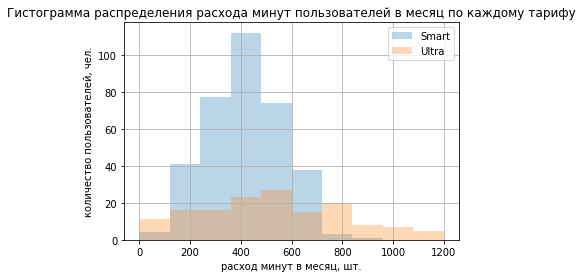

In [42]:
users_tarif_mean_per_user.groupby('tariff')['calls_duration'].hist(bins=10, range=(0, 1200), alpha=0.3)
plt.title('Гистограмма распределения расхода минут пользователей в месяц по каждому тарифу')
plt.xlabel('расход минут в месяц, шт.')
plt.ylabel('количество пользователей, чел.')
plt.legend(['Smart', 'Ultra'])
plt.show()


>1. Около 34% пользователей тарифа **smart** "переговаривают" свой тариф, а вот пользователи **ultra** в тариф укладываются на 100%
>2. На тарифе **smart** большинство пользователей (почти 45%) расходуют в месяц от 400 до 480 минут.
>3. Около 65% пользователей **smart** в тариф по звонкам укладываются
>4. На тарифе **ultra** пользователи в основном тратят от 500 до 600 минут в месяц, а также от 300 до 500 минут. Как видно, в среднем все не только укладываются в пакет, но и не "договаривают" почти 60% минут, за которые заплачено.
>5. 30% пользователей **ultra** переплачивают за звонки, поскольку на самом деле укладываются в пакет **smart**, который в 3,5 раза дороже. Но судить рано, посмотрим, как обстоят дела с другими услугами

#### Анализ ежемесячного расходования интренет-трафика

In [43]:
users_tarif_mean_per_user.groupby('tariff')['gb_used'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,350.0,16.308519,3.501643,5.727273,14.000000,16.333333,18.691667,27.25
ultra,148.0,19.588446,8.116120,0.000000,14.727273,18.775000,25.687500,38.50


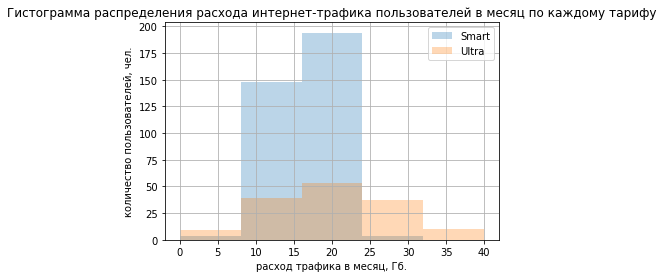

In [44]:
users_tarif_mean_per_user.groupby('tariff')['gb_used'].hist(bins=5, range=(0, 40), alpha=0.3)
plt.title('Гистограмма распределения расхода интернет-трафика пользователей в месяц по каждому тарифу')
plt.xlabel('расход трафика в месяц, Гб.')
plt.ylabel('количество пользователей, чел.')
plt.legend(['Smart', 'Ultra'])
plt.show()

>1. На обоих тарифах в основном тратят от 16 до 24 гб
>2. На тарифе **smart** больше половины людей (около 60%) расходует трафик сверх своего пакета.
>3. На тарифе **ultra** не укладываются в свой пакет 14% пользователей. А остальный 86% в пакет укладываются.
>4. Порядка 37% пользователей тарифа **ultra** укладываются в дешевый пакет **smart** по количеству расходуемого интернета. Остальные 49% укладываются именно в свой тариф, а 14% (как было упомянуто в п.3.) дорогой тариф вообще превышают.
>5. На ультре все 25-30 Гб расходуют меньше 20% пользователей. 
>6. Пока что реальное преимущество ультры для пользователя только в количестве Гб

#### Анализ ежемесячного количества отправленных сообщений

In [45]:
users_tarif_mean_per_user.groupby('tariff')['messages'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,350.0,32.352078,26.512448,0.0,11.0,27.75,48.00,118.0
ultra,148.0,54.030743,46.366246,0.0,17.0,45.50,84.25,192.0


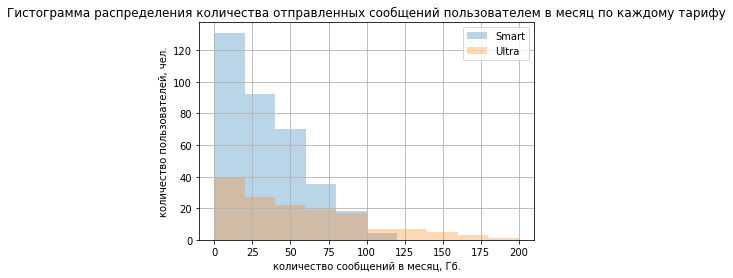

In [46]:
users_tarif_mean_per_user.groupby('tariff')['messages'].hist(bins=10, range=(0, 200), alpha=0.3)
plt.title('Гистограмма распределения количества отправленных сообщений пользователем в месяц по каждому тарифу')
plt.xlabel('количество сообщений в месяц, Гб.')
plt.ylabel('количество пользователей, чел.')
plt.legend(['Smart', 'Ultra'])
plt.show()

>1. На обоих тарифах в лидеры выбивается до 20 сообщений в месяц. Это 37% на тарифе **smart** и 27% на **ultra**
>2. Больше 70% людей укладываются в положенный лимит в 50 сообщений. Остальные 30 его превышают. На тарифе **smart** примерно трети людей свойственно превышение лимита по своему тарифу
>3. **Ультра** молодцы. Укладываются на 100% в свои 3000 сообщений. Однако максимальное количество сообщений по выборке это 192. То есть на самом деле используется менее 6,4 % от всего количества сообщений. 
>4. Около 55% пользователей тарифа **Ultra** укладываются по сообщениям в дешевый тариф. 35% отправляют до 100 сообщений в месяц, и только порядка 10% могут похвастаться количеством сообщений после 100. Однако их число очень невелико. 

>Пока кажется, что за тариф ультра люди переплачивают, не используя все услуги, которые включены в пакет.  
>
>На тарифе ультра "Мегалайн" несет меньший фактический расход за предоставление услуг, которые в пакет включены. Опцию 30 Гб интернет-трафика используют довольно активно, но на 100% все равно всего около 15%. Соответственно за остальные Гб компании платить не надо. Смс не расходуются практически на 96%, а звонки на 60%. Довольно неплохо для компании. Пользователь платит в 3,5 раза больше, а фактических затрат на него не сильно больше, чем на самом простом тарифе за 550 рублей.

## Гипотезы

Проверим гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. Средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.  

Будем использовать метод ttest_ind, т.к в обоих случаях нам надо проверить гипотезу о равенстве средних двух генеральных совокупностей

#### Гипотеза №1 - Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются

За нулевую гипотезу (Н0) принимаем форумлировку: "средняя выручка пользователей тарифов "Ультра" и "Смарт" равна.  
Альтернативная гипотеза (H1): "средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются.  

In [47]:

smart_income = users_tarif_mean_per_user.query('tariff == "smart"')['income_per_user']
ultra_income = users_tarif_mean_per_user.query('tariff == "ultra"')['income_per_user']

#smart_income.describe()
#ultra_income.describe()

print('Средняя выручка по пользователю тарифа Smart:', smart_income.median())
print('Средняя выручка по пользователю тарифа Ultra:', ultra_income.median())

alpha = 0.05

results = st.ttest_ind(smart_income, ultra_income, equal_var = False) #добавим параметр equal_var = False, т.к. средние отклонения сильно различаются
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



Средняя выручка по пользователю тарифа Smart: 1177.1166666666668
Средняя выручка по пользователю тарифа Ultra: 1950.0
p-значение: 2.084961899583595e-59
Отвергаем нулевую гипотезу


#### Гипотеза №2 - Средняя выручка пользователя из Москвы отличается от выручки пользователей из других регионов.




За нулевую гипотезу (Н0) принимаем форумлировку: "средняя выручка пользователей из Москвы равна выручке пользователей из других регионов"  
Альтернативная гипотеза (H1): "средняя выручка пользователей из Москвы и выручка пользователей из других регионов отличаются" 

In [48]:
moscow = users_final.query('city == "Москва"')
moscow_income_per_user = moscow.pivot_table(index = ['user_id'], values = ['income_per_user'], aggfunc = 'median')
#display(moscow_income_per_user)
#moscow_income_per_user.describe()

In [49]:
region = users_final.query('city != "Москва"')
region_income_per_user = region.pivot_table(index = ['user_id'], values = ['income_per_user'], aggfunc = 'median')
#display(region_income_per_user)
#region_income_per_user.describe()

In [50]:
print('Средняя выручка по пользователю из Москвы:', moscow_income_per_user.median())
print('Средняя выручка по пользователю из регионов:', region_income_per_user.median()) 

alpha = 0.05

results = st.ttest_ind(moscow_income_per_user, region_income_per_user) #убираем параметр equal_var = False, т.к. средние отклонения не сильно различаются
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка по пользователю из Москвы: income_per_user    1559.0
dtype: float64
Средняя выручка по пользователю из регионов: income_per_user    1550.0
dtype: float64
p-значение: [0.32359779]
Не получилось отвергнуть нулевую гипотезу


## Результаты исследования

1. Тариф Смарт пользуется большей популярностью у людей. Его выбирают более чем в 2 раза чаще, чем тариф Ультра
2. В среднем около 30% пользователей тарифа Смарт расходуют большее количество услуг смс и звонков. И более 60% превышают количество Гб
3. Пользователи тарифа Ультра в пакет укладываются практически в 100% случаях. Более того - 60% не расходует пакет звонков, а более 90% не расходует пакет смс.
4. Средняя выручка на пользователя по тарифу Ультра составляет 1950 рублей. Пользователи пакета Ультра редко выходит за рамки базовой ежемесячной платы и сверх почти не тратят.
5. Средняя выручка на пользователя по тарифу смарт составляет 1177 рублей, что на 2,14 раз превышает покупку базового пакета в 550 рублей. 
6. В среднем все пользователи тарифа Смарт за один период времени принесут оператору около 411 950 рублей, а пользователи Ультра 288 600, что в 1,5 раза ниже. 
7. Есть преимущества - тариф Ультра не используется на 100%, соответственно оператор существенно экономит на предоставляемых услугах. А тариф Смарт дает сверхприбыль более чем в 2 раза от своего тарифа
8. Если мы узнаем затраты оператора на предоставляемые услуги связи, а также затраты на привлечение клиента по обоим тарифам, мы сможем определить, какой тариф будет более выгодным для компании. Ведь экономия на Ультре может быть и равна сверхприбыли от Смарта, средний САС по смарту существенно ниже Ультры. В итоге и маржинальность также будет отличаться.
9. Перспективней именно для развития на данный момент выглядит тариф Ультра - существенная экономия на расходах, нет претензий от людей "я переплатил" и выше средний чек. Но придется вложиться в продвижение. Пока что тариф не такой популярный, как Смарт. 
10. Итоговой выручки по всем клиентам сейчас приносит больше Смарт, а средняя выручка на пользователя выше у Ультра. Однако опять же, мы не знаем всех затрат, а видим только выручку по клиенту, что является неверной трактовкой для определения перспективности развития того или иного тарифа.
11. Возможно, также стоит задуматься и о третьем тарифе (среднее между Смарт и Ультра), чтобы с одной стороны увеличить средний чек, снизить нагрузку на отдел по работе с клиентами (предполагаю, что вопросов по переплате у смартовцев много), создать среднюю экономию на затратах, с другой стороны снизить затраты на продвижение не сильно популярного тарифа, включить в тариф большее количество Гб интернета (а может быть сделать его безлимитным. Привлекательно для продажи, по фактическим затратам, как показывает наше исследование, мало кто тратит много) сделать сообщения безлимитными (ими все равно никто не пользуется), и определить наиболее выгодный порог для звонков. Также в среднем тарифе можно легко увеличить стоимость за сверхуслуги. Сейчас между стоимостями как самих пакетов, так и сверхуслуг очень большой разрыв. Но все это можно планировать только после п.8
